In [ ]:
# uncomment if issue module not installed appears
#!pip install nltk
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import unicodedata
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stops
from nltk.corpus import stopwords as nltk_stopwords
from nltk import download as nltk_download
import re

# Load corrected CSV
df = pd.read_csv("tei_speaker_lines_with_corrected_year.csv")

# Optional: Remove rows with missing or invalid years
df = df[df['Year'].apply(lambda x: str(x).isdigit())]
df['Year'] = df['Year'].astype(int)


Aggregate lines by year

In [2]:
# Group all lines per year into one big text blob
lines_by_year = df.groupby('Year')['Line'].apply(lambda texts: ' '.join(texts)).reset_index()


In [3]:
top_n = 10  # number of top words per year

In [4]:
# Download NLTK stopwords if not already
nltk_download("stopwords")

# Initialize minimal SpaCy pipeline (no models loaded)
nlp = English()

# Shakespeare-specific stopwords
shakespeare_stopwords = {
    "thou", "thee", "thy", "thine", "ye", "hast", "hath", "dost", "doth",
    "wilt", "shalt", "shall", "wouldst", "couldst", "shouldst", "didst",
    "ere", "wherefore", "whence", "hence", "thence", "oft", "nay", "yea",
    "'tis", "tis", "'twas", "twas", "’tis", "’twas", "o’er", "e’en", "ne’er",
    "i’", "th’", "methinks", "perchance", "prithee", "fain", "anon", "lo",
    "’em", "'em", "em", "’ll", "'ll", "ll", "’d", "'d", "’re", "'re", "re",
    "st", "th", "ain"
}

# Combine stopwords: SpaCy, NLTK, Shakespeare
combined_stopwords = spacy_stops.union(set(nltk_stopwords.words("english"))).union(shakespeare_stopwords)

# Unicode punctuation check
def is_punctuation(token):
    return all(unicodedata.category(char).startswith('P') for char in token)

def clean_text(text):
    doc = nlp(text.lower().replace("’", "'"))  # Normalize apostrophes
    tokens = [
        token.text.strip(".,!?;:-—’'\"()[]")
        for token in doc
        if token.text.strip(".,!?;:-—’'\"()[]") not in combined_stopwords
        and not is_punctuation(token.text)
        and not token.is_space
    ]
    return ' '.join(tokens)

def normalize_shakespeare(text):
    # Normalize 2nd-person singular verb forms (e.g., call’st → call)
    text = re.sub(r"\b(\w+)[’']st\b", r"\1", text)
    # Normalize archaic will contractions (e.g., thou’lt → thou)
    text = re.sub(r"\b(\w+)[’']lt\b", r"\1", text)
    # Remove standalone contractions (e.g., 'tis → tis)
    text = re.sub(r"[’']", "", text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanakpandit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Prepare plot data containers
years = []
words = []
frequencies = []

for _, row in lines_by_year.iterrows():
    year = row['Year']
    raw_text = row['Line'].lower()
    normalized_text = normalize_shakespeare(raw_text)
    cleaned_text = clean_text(normalized_text)

    # Vectorize for this year's text
    vectorizer = CountVectorizer(stop_words=None)
    X = vectorizer.fit_transform([cleaned_text])
    word_counts = X.toarray().flatten()
    vocab = vectorizer.get_feature_names_out()

    # Get top N words for the year
    top_indices = word_counts.argsort()[-top_n:][::-1]
    top_words = vocab[top_indices]
    top_counts = word_counts[top_indices]

    # Collect data for plotting
    for w, c in zip(top_words, top_counts):
        years.append(year)
        words.append(w)
        frequencies.append(c)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'Year': years,
    'Word': words,
    'Frequency': frequencies
})

Normalize bubble sizes for visualization

In [6]:
max_freq = plot_df['Frequency'].max()
plot_df['Size'] = plot_df['Frequency'] / max_freq * 1000  # scale sizes

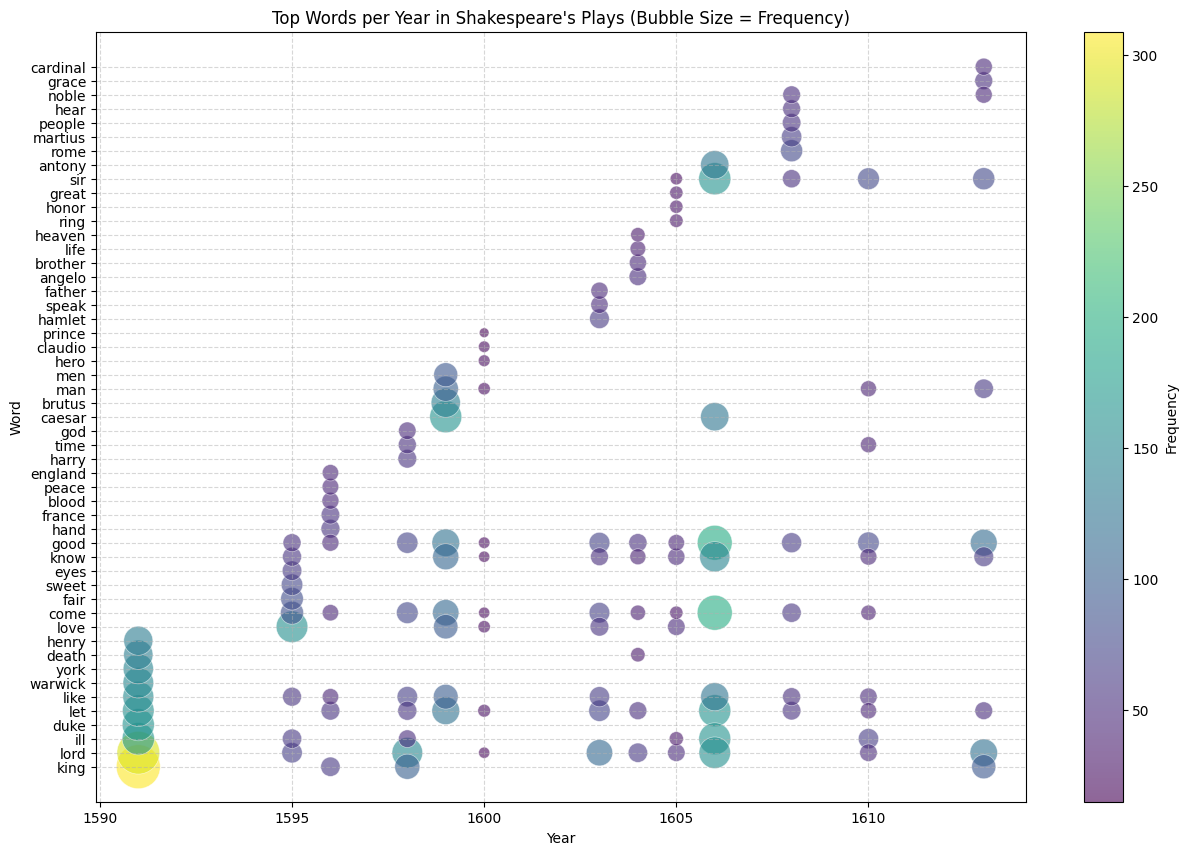

In [7]:
# Create bubble plot
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    plot_df['Year'], 
    plot_df['Word'], 
    s=plot_df['Size'], 
    alpha=0.6, 
    edgecolors="w", 
    linewidth=0.5,
    c=plot_df['Frequency'], cmap='viridis'
)
plt.colorbar(scatter, label='Frequency')
plt.xlabel("Year")
plt.ylabel("Word")
plt.title("Top Words per Year in Shakespeare's Plays (Bubble Size = Frequency)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()